# Pareto Q-Learning

Pareto Q-learning (PQL) is a multi-objective reinforcement learning (MORL) algorithm that learns a set of Pareto-optimal policies. The algorithm is based on the Q-learning algorithm, but it uses a multi-objective Q-function to learn a set of policies that are optimal with respect to multiple objectives. **It is a multi-policy algorithm that learns a set of Pareto dominating policies in a single run.** The key features of PQL are as follows:

* tabular method
* multi-policy algorithm
* bootstraps sets of Q-vectors
* separates the expected immediate reward vector from the set of expected future discounted reward vectors
* set evaluation mechanism for exploration
* consistently tracking a policy

Ok, let's dive into the details of the algorithm.

> Note: We assume that you are familiar with single-objective RL and basic concepts of multi-objective RL. If not, please refer to the [MORL Introduction](introduction.ipynb) notebook.

References:

* **Paper**: [Multi-Objective Reinforcement Learning using Sets of Pareto Dominating Policies](https://www.jmlr.org/papers/volume15/vanmoffaert14a/vanmoffaert14a.pdf)  
* **Source Code**: [LucasAlegre/morl_baselines/multi_policy/pareto_q_learning/pql.py (Github)](https://github.com/LucasAlegre/morl-baselines/blob/main/morl_baselines/multi_policy/pareto_q_learning/pql.py)

In [1]:
# Import all necessary libraries
import gymnasium as gym
import matplotlib.pyplot as plt
import mo_gymnasium as mo_gym
import numpy as np
from IPython import display
from pymoo.indicators.hv import HV

from src.pareto import get_non_dominated

## Background

In this section, we present the brief background necessary to understand PQL. First of all, we introduce a multi-objective markov decision process (MOMDP):

* state space $S = \{ s_1, \dots, s_N \}$
* action space $A = \{ a_1, \dots, a_r \}$
* transition probability $T(s' \vert s,a)$
* reward vector function $\mathbf{R}(s,a) = (R_1(s,a), \dots, R_m(s,a))$
* discount factor $\gamma \in [0,1]$

where $m$ is the number of objectives. The goal of the MOMDP is to find a set of policies that are optimal with respect to multiple objectives. In this case, the value function is vectorial given policy $\pi(a \vert s)$:

$$
\mathbf{V}^\pi(s) = \mathbb{E}_\pi \left[ \sum_{t=0}^\infty \gamma^t \mathbf{R}(s_t, a_t) \vert s_0 = s \right] \tag{1}
$$

Multi-policy algorithms do not reduce the dimensionality of the objective space but aim to learn a set of optimal solutions at once. In the case of the dynamic programming (DP) algorithm that computes a set of Pareto dominating policies, the DP function is defined as follows:

$$
\hat{Q}_{set}(s,a) = \mathbf{R}(s,a) \oplus \gamma \sum_{s' \in S} T(s' \vert s,a) V^{ND}(s') \tag{2}
$$

where $V^{ND}(s')$ is the set of non-dominated vectors of the $\hat{Q}_{set}$'s of each action in $s'$:

$$
V^{ND}(s') = ND(\cup_{a'} \hat{Q}_{set}(s',a')) \tag{3}
$$

and $\oplus$ operator performs a vector-sum between a vector $\mathbf{v}$ and a set of vectors $V$:

$$
\mathbf{v} \oplus V = \bigcup_{\mathbf{v'} \in V} (\mathbf{v} + \mathbf{v'}) \tag{4}
$$

Of course, the DP function assumes a perfect knowledge of the environment, i.e., it's model-based.

## Method

Pareto Q-learning is based on the above DP function and learns deterministic non-stationary policies. Also, it works model-free.

### Set Evaluation Mechanism

In the conventional Q-learning algorithm, the agent selects an action based on the scalar Q-values. But, in multi-policy algorithms, there exist Q-vector sets not scalar Q-values. Thus, for ordering the Q-vector sets for each action $a$, PQL introduces a set evaluation mechanism that obtains a scalar evaluation of the Q-vector set $\hat{Q}_{set}(s,a)$. The authors proposed three evaluation mechanisms, but we will focus on only the hypervolume set evaluation mechanism for simplicity. Refer to the paper for the other two mechanisms.

Hypervolume is a measure of the volume of the objective space dominated by a set of non-dominated policies: a Pareto front (see below figure).

![](img/pql/hypervolume.png)

This measure is well-suited for two reasons:

1. the only quality indicator to be strictly monotonic with the Pareto dominance relation
2. provides a scalar measure of a set of non-dominated vectors 

The evaluation algorithm is as follows:

![](img/pql/hypervolume-evaluation-algorithm.png)

Then, the calculated evaluations can be used in action selection strategy (e.g., $\epsilon$-greedy), similar to the conventional Q-learning. The crucial parameter is the reference point. This parameter is problem-specific and should be chosen with great care.

Okay, let's implement the evaluation mechanism and policy in Python.

In [2]:
def hypervolume(ref_point: np.ndarray, points: np.ndarray) -> float:
    # -1 for maximization problems
    return HV(ref_point=ref_point * -1)(points * -1)

In [3]:
class Policy:
    def __init__(self, ref_point: np.ndarray, n_actions: int):
        self.ref_point = ref_point
        self.n_actions = n_actions
    
    def select_action(self, q_vec_sets, epsilon=0.1) -> int:
        """Select an action given the current Q-vector sets."""
        # epsilon-greedy policy
        if np.random.rand() < epsilon:
            return np.random.randint(self.n_actions)
        else:
            action_evals = self.hypervolume_eval(q_vec_sets)
            # select randomly among actions with the highest value
            return np.random.choice(np.argwhere(action_evals == np.max(action_evals)).flatten())
    
    def hypervolume_eval(self, q_vec_sets):
        hypervolumes = []
        # calculate hypervolume for each action
        for action in range(self.n_actions):
            q_vec_set = q_vec_sets[action]
            hv = hypervolume(self.ref_point, np.array(list(q_vec_set)))
            hypervolumes.append(hv)
        return np.array(hypervolumes)

### Set-Based Bootstrapping

How to update the set of vectors of the current state-action $(s,a)$-pair with an observed reward vector $\mathbf{r}$ and a set of non-dominated vectors of the next state $ND(\cup_{a'} \hat{Q}_{set}(s',a'))$ over time? The main problem is the lack of *correspondence*, i.e., it is not clear which vector of the set of the current $(s,a)$-pair to update with which vector in $s'$ (see below figure).

![](img/pql/set-based-bootstrapping.png)

To solve this problem, PQL utilizes the idea of storing two estimates separately: the average observed immediate reward vector $\overline{\mathfrak{R}}(s,a)$ and the set of non-dominated vectors $ND_t(s,a)$ in the next state of $s$ that is reached through action $a$ at time step $t$. The $\hat{Q}_{set}(s,a)$ can be calculated *at run time* by performing a vector-sum over the average immediate reward vector and the set of discounted Pareto dominating future rewards:

$$
\hat{Q}_{set}(s,a) \leftarrow \overline{\mathfrak{R}}(s,a) \oplus \gamma ND_t(s,a) \tag{5}
$$ 

Since it doesn't store $\hat{Q}_{set}(s,a)$ and calculates the set at run time, no explicit correspondence between the two sets is required. The overall PQL algorithm is as follows:

![](img/pql/pareto-q-learning-algorithm.png)

Okay, let's implement the PQL algorithm in Python!

In [4]:
class PQL:
    def __init__(self, env: gym.Env, eval_env: gym.Env, ref_point: np.ndarray, gamma=0.99, init_eps=1.0, eps_decay=0.995):
        self.env = env
        self.eval_env = eval_env
        # asumme that both the state space and the action space are discrete
        self.n_states = env.observation_space.n
        self.n_actions = env.action_space.n
        self.n_objectives = env.unwrapped.reward_space.shape[0]
        
        self.ref_point = ref_point
        self.gamma = gamma
        self.eps = init_eps
        self.eps_decay = eps_decay
        
        # initialize the policy
        self.policy = Policy(self.ref_point, self.n_actions)
        
        # initialize the average reward vectors and the non-dominated sets
        self.counts = np.zeros((self.n_states, self.n_actions))
        self.avg_reward_vectors = np.zeros((self.n_states, self.n_actions, self.n_objectives))
        # non_dominated_sets[s][a] is a set of non-dominated Q-vectors
        self.non_dominated_sets = [
            [{tuple(np.zeros(self.n_objectives))} for _ in range(self.n_actions)] for _ in range(self.n_states)
        ]
        
    def calc_q_vec_set(self, state, action):
        # (n_vectors, n_objectives)
        ND = np.array(list(self.non_dominated_sets[state][action]))
        # (n_objectives,)
        avg_reward_vec = self.avg_reward_vectors[state, action]
        # (n_vectors, n_objectives)
        q_vec_set = avg_reward_vec + self.gamma * ND
        return {tuple(q_vec) for q_vec in q_vec_set}
    
    def calc_non_dominated_set(self, state: int):
        q_vec_sets = [self.calc_q_vec_set(state, action) for action in range(self.n_actions)]
        candidates = set().union(*q_vec_sets)
        non_dominated = get_non_dominated(candidates)
        return non_dominated
    
    def train(self, n_episodes: int):
        for _ in range(n_episodes):
            # initialize state
            state, _ = self.env.reset()
            terminated = False
            truncated = False
            
            while not (terminated or truncated):
                # select action using a policy
                q_vec_sets = [self.calc_q_vec_set(state, action) for action in range(self.n_actions)]
                action = self.policy.select_action(q_vec_sets, epsilon=self.eps)
                next_state, reward_vector, terminated, truncated, _ = self.env.step(action)
                
                # update the current non-dominated set and the current average reward vector
                self.non_dominated_sets[state][action] = self.calc_non_dominated_set(next_state)
                self.counts[state, action] += 1
                self.avg_reward_vectors[state, action] += (reward_vector - self.avg_reward_vectors[state, action]) / self.counts[state, action]
                
                # proceed to the next state
                state = next_state
                
        return self.calc_non_dominated_set(state=0)

### Consistently Tracking a Policy

In multi-policy setting, you need to select actions *consistently* in order to retrieve a desired policy based on the $\hat{\mathbf{Q}}$-vectors. If you would select actions based on *local* information about the 'local' Pareto front attainable from each action, then there is no guarantee that the cumulative reward vectors obtained throughout the episode will be *globally* Pareto optimal. In other words, when in a state where multiple actions are considered non-dominated and therefore are incomparable, you should not randomly select between these actions when exploiting but actions need to be selected consistently (see below figure).

![](img/pql/policy-tracking.png)

To solve the problem, PQL defines a globally greedy policy as a policy $\pi$ that consistently *follows* or *tracks* a given expected return vector $\mathbf{V}^\pi(s)$ from a state $s$ so that its return equals $\mathbf{V}^\pi(s)$ in expectation. 

But, How? First of all, for each action, the agent retrieves both $\mathfrak{R}(s,a)$ and $ND_t(s,a)$. Then, if the sum of these two components equals the target return vector $\mathbf{V}^\pi(s)$ to follow, the agent selects the corresponding action, proceeds to the next state and updates the target. The policy tracking algorithm is as follows:

![](img/pql/policy-tracking-algorithm.png)

Okay, let's implement the policy tracking algorithm in Python!

In [5]:
def track_policy(pql: PQL, env: gym.Env, target: np.ndarray):
    # initialize state
    state, _ = env.reset()
    terminated = False
    truncated = False
    cumulativbe_reward_vec = np.zeros(pql.n_objectives)
    current_gamma = 1.0
    tol = 1e-3
    
    while not (terminated or truncated):
        closest_dist = np.inf
        closest_action = 0
        found_action = False
        new_target = target
        
        for action in range(pql.n_actions):
            reward_vec = pql.avg_reward_vectors[state, action]
            ND = pql.non_dominated_sets[state][action]
            # find the closest Q-vector to the target
            for Q in ND:
                Q = np.array(Q)
                dist = np.sum(np.abs(pql.gamma * Q + reward_vec - target))
                if dist < closest_dist:
                    closest_dist = dist
                    closest_action = action
                    new_target = Q
                    
                    if dist < tol:
                        found_action = True
                        break
                    
                if found_action:
                    break
                
        # take the action
        state, reward, terminated, truncated, _ = env.step(closest_action)
        cumulativbe_reward_vec += current_gamma * reward
        current_gamma *= pql.gamma
        # update the target
        target = new_target
    
    return cumulativbe_reward_vec

## Run

We will experiment with the PQL algorithm on the Deep Sea Treasure environment. This environment is classic MORL problem in which the agent controls a submarine in a 2D grid world. It has two objectives and is known to have the non-convex (concave) Pareto front. See details in [MO-Gymnasium/Deep-Sea-Treasure-Concave](https://mo-gymnasium.farama.org/environments/deep-sea-treasure-concave/).

PQL can solve non-convex Pareto front problems since it treats every Pareto optimal solution equally in the bootstrapping process. We will show that it can really do that through the experiment.

In [6]:
env = mo_gym.make("deep-sea-treasure-v0")

print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")
print(f"Reward space: {env.unwrapped.reward_space}")

Observation space: Box(0, 11, (2,), int32)
Action space: Discrete(4)
Reward space: Box([ 0. -1.], [23.7 -1. ], (2,), float32)


Since the observation space is `Box` and has `(2,)` shape, we will convert it to `Discrete` for compatibility with our `PQL`.

In [7]:
class GridToDiscreteWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super(GridToDiscreteWrapper, self).__init__(env)
        self.env_shape = self.observation_space.high - self.observation_space.low + 1
        self.observation_space = gym.spaces.Discrete(np.prod(self.env_shape))
    
    def observation(self, observation):
        return np.ravel_multi_index(observation, self.env_shape)

Initialize the environment.

In [8]:
GAMMA = 0.99
REF_POINT = np.array([0, -25])
EVAL_FREQ = 20
TOTAL_EPISODES = 10000

env = mo_gym.make("deep-sea-treasure-concave-v0")
env = GridToDiscreteWrapper(env)

eval_env = mo_gym.make("deep-sea-treasure-concave-v0")
eval_env = GridToDiscreteWrapper(eval_env)

print(f"Observation space: {env.observation_space}")

Observation space: Discrete(144)


Initialize the PQL agent.

In [9]:
pql = PQL(env, eval_env, ref_point=REF_POINT, gamma=GAMMA)

Training start!

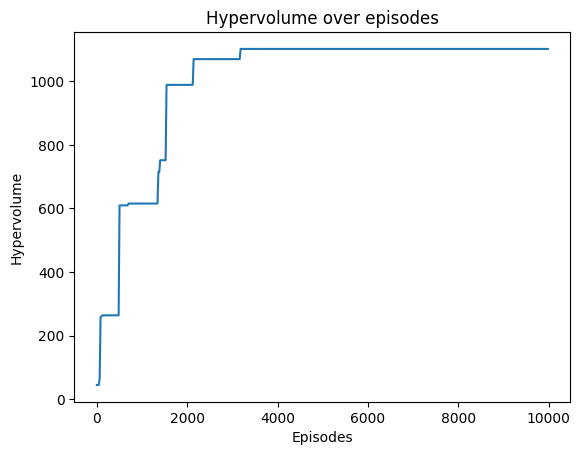

In [10]:
episodes = []
hv_list = []

for i in range(TOTAL_EPISODES // EVAL_FREQ):
    pf = pql.train(EVAL_FREQ)
    hv = hypervolume(REF_POINT, np.array(list(pf)))
    hv_list.append(hv)
    episodes.append(i * EVAL_FREQ)
    
    display.clear_output(wait=True)
    plt.plot(episodes, hv_list)
    plt.xlabel("Episodes")
    plt.ylabel("Hypervolume")
    plt.title("Hypervolume over episodes")
    plt.show()

You can see that the performance is continuously improving. Now, let's visualize the Pareto front of the learned policies.

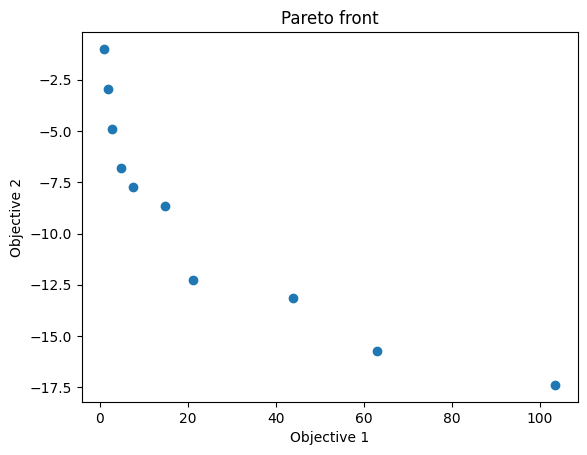

In [11]:
pf_evals = []
for target in pql.calc_non_dominated_set(state=0):
    pf_eval = track_policy(pql, eval_env, target)
    pf_evals.append(pf_eval)
    
pf_evals = np.array(pf_evals)
    
plt.scatter(pf_evals[:, 0], pf_evals[:, 1])
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.title("Pareto front")
plt.show()

You can see that the Pareto front is non-convex or concave. Also, the PQL algorithm can learn a variety of policies that are Pareto optimal.